In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
cpu = 40

In [3]:
def calculate_node_portion(sub_df):
    nodes_records = {}
    for k, v in node_cluster_dict.items():
        left = v['left']
        right = v['right']

        # left hypo, right hyper
        judge_from_left = sub_df['cluster_from'].apply(lambda i: i in left)
        judge_to_right = sub_df['cluster_to'].apply(lambda i: i in right)

        # right hypo, left hyper
        judge_from_right = sub_df['cluster_from'].apply(lambda i: i in right)
        judge_to_left = sub_df['cluster_to'].apply(lambda i: i in left)

        # this two cancel each other, use the remaining abs as real hits
        # positive means left hypo, negative means right hypo
        total = (judge_from_left & judge_to_right).sum() -\
                (judge_from_right & judge_to_left).sum()
        nodes_records[k] = total
    nodes_records = pd.Series(nodes_records) / node_possible_count
    return nodes_records

In [7]:
node_cluster_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)
related_dmg = pd.read_msgpack('TotalPairwiseMarker.with_rate.msg')

gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
node_possible_count = {}
for node, sub_dict in node_cluster_dict.items():
    possible_pairs = len(sub_dict['left']) * len(sub_dict['right'])
    node_possible_count[node] = possible_pairs
node_possible_count = pd.Series(node_possible_count)

In [11]:
related_dmg = related_dmg[related_dmg['from_rate'] > related_dmg['to_rate']].copy()

In [12]:
related_dmg[related_dmg['gene_name'] == 'Cux2']

,pvals_adj,gene_id,cluster_from,cluster_to,gene_name,-lgp,AUROC,from_rate,to_rate
575,2.272777e-127,ENSMUSG00000042589.18,IT-L5+ACA-3,IT-L23+ORB,Cux2,126.643443,0.934314,1.587588,0.555286
698,5.356149e-131,ENSMUSG00000042589.18,IT-L5+MOs-1,IT-L23+ORB,Cux2,130.271147,0.941224,1.786470,0.555286
372,2.248207e-140,ENSMUSG00000042589.18,IT-L5+ORB,IT-L23+ORB,Cux2,139.648164,0.965995,1.781819,0.555286
448,3.249717e-136,ENSMUSG00000042589.18,IT-L5+MOs-2,IT-L23+ORB,Cux2,135.488154,0.964784,1.740071,0.555286
481,4.611262e-98,ENSMUSG00000042589.18,IT-L5+PFC-1,IT-L23+ORB,Cux2,97.336180,0.892162,1.755118,0.555286
463,5.942548e-101,ENSMUSG00000042589.18,IT-L5+PFC-2,IT-L23+ORB,Cux2,100.226027,0.903686,1.738659,0.555286
680,3.237891e-131,ENSMUSG00000042589.18,IT-L5+MOp-3,IT-L23+ORB,Cux2,130.489738,0.962685,1.724879,0.555286
574,2.846813e-141,ENSMUSG00000042589.18,IT-L5+AI,IT-L23+ORB,Cux2,140.545641,0.984281,1.949883,0.555286
366,1.069852e-87,ENSMUSG00000042589.18,IT-L5+ACA-1,IT-L23+ORB,Cux2,86.970676,0.882166,1.614882,0.555286
634,5.289332e-125,ENSMUSG00000042589.18,IT-L5+MOp-4,IT-L23+ORB,Cux2,124.276599,0.957531,1.753294,0.555286


In [13]:
total_result = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for gene, sub_df in related_dmg.groupby('gene_id'):
        future = executor.submit(calculate_node_portion, sub_df)
        futures[future] = gene
        
    for future in as_completed(futures):
        result = future.result()
        gene = futures[future]
        total_result[gene] = result
total_result = pd.DataFrame(total_result)

In [14]:
mask_cutoff = 0.3

masked_result = total_result.copy()
masked_result[masked_result.abs() < 0.3] = 0

In [15]:
# gene that assign to at least one node
((masked_result != 0).sum(axis=0) != 0).sum()

1129

In [16]:
# node that has at least 5 genes
((masked_result != 0).sum(axis=1) > 5).sum()

38

In [17]:
masked_result.apply(lambda i: 0 if i.abs().max() == 0 else i.abs().idxmax(), axis=0)

ENSMUSG00000019889.10      0
ENSMUSG00000021820.18      0
ENSMUSG00000009614.16      0
ENSMUSG00000019888.16      0
ENSMUSG00000020183.11      0
                        ... 
ENSMUSG00000118445.1     142
ENSMUSG00000118436.1       0
ENSMUSG00000118412.1     142
ENSMUSG00000118416.1     143
ENSMUSG00000118401.1       0
Length: 4977, dtype: int64

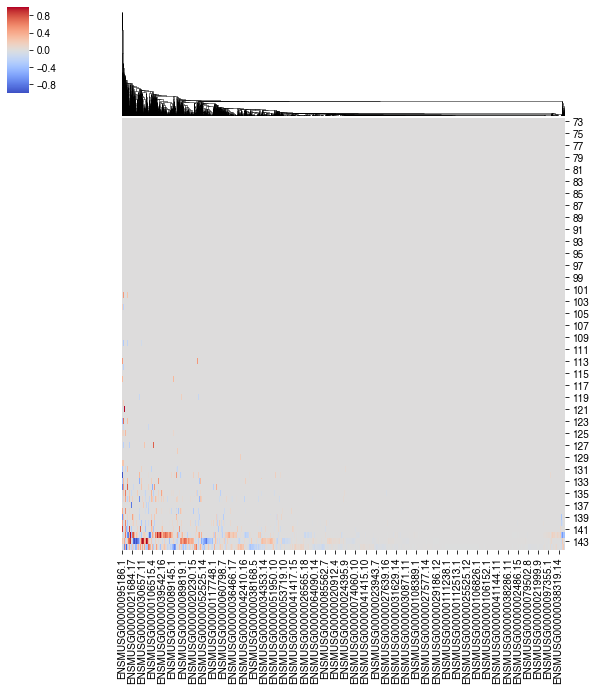

In [18]:
sns.clustermap(total_result, row_cluster=False, cmap='coolwarm')

In [19]:
total_result.to_msgpack('NodeGeneResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


In [27]:
gene_meta.loc[total_result.columns[total_result.loc[141] > 0]]['gene_name']

ENSMUSG00000020173.17          Cobl
ENSMUSG00000020160.18         Meis1
ENSMUSG00000021782.14          Dlg5
ENSMUSG00000010066.15      Cacna2d2
ENSMUSG00000020121.15        Srgap1
                            ...    
ENSMUSG00000117179.1        Gm49907
ENSMUSG00000117652.1         Gm2350
ENSMUSG00000118170.1     AC152076.4
ENSMUSG00000117764.1     AC157784.1
ENSMUSG00000118362.1        Gm19466
Name: gene_name, Length: 368, dtype: object

In [41]:
gene_meta.loc[total_result.columns[total_result.loc[136] < -0.5]]['gene_name'].tolist()

['Pcyt1a', 'Satb1', 'Ddah1', 'Astn2', 'Antxr1', 'Tafa2', 'Efna5', 'Grm4']

In [35]:
value = total_result[gene_name_to_id['Pcdh17']]

In [37]:
value[value.abs() > 0.5]

132   -0.633333
134   -1.000000
137    1.000000
139   -0.666667
140    0.518519
141    0.722222
Name: ENSMUSG00000035566.7, dtype: float64